<a href="https://colab.research.google.com/github/mohammadRahimi1993/BigData/blob/main/pyRDF2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyRDF2vec
!pip install rdflib
!pip install aiohttp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 57 kB 4.5 MB/s 
     |████████████████████████████████| 204 kB 60.6 MB/s 
     |████████████████████████████████| 11.2 MB 44.0 MB/s 
     |████████████████████████████████| 50 kB 6.6 MB/s 
     |████████████████████████████████| 944 kB 54.6 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149877 sha256=4eea3828cac056258bafccf5e1566dd2dd9a59a1666f5c18a3229fcf11ae9e90
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
  Created wheel for python-louvain: filename=python_louvain-0.15-py3-none-any.whl size=9413 sha256=850646915a882d2937cdb196c29eace6b1604f495bcb52f3a7da85824f2f7435
  Stored in directory: /root/.cache/pip/wheels/c7/4c/ef/427db8777620f7fa12a6404f1527a39536a812f46a4d1044d3
Successfully built python-Levenshtein python-louv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 482 kB 30.5 MB/s 
     |████████████████████████████████| 41 kB 693 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 29.9 MB/s 
     |████████████████████████████████| 94 kB 756 kB/s 
     |████████████████████████████████| 271 kB 77.7 MB/s 
     |████████████████████████████████| 144 kB 69.3 MB/s 


In [30]:
import pandas as pd
from pyrdf2vec import RDF2VecTransformer
from pyrdf2vec.embedders import Word2Vec
from pyrdf2vec.graphs import KG
from pyrdf2vec.walkers import RandomWalker
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from pyrdf2vec.samplers import WideSampler
from pyrdf2vec.walkers import HALKWalker

In [ ]:
# Cloning the pyRDF2Vec repo
!git clone https://github.com/IBCNServices/pyRDF2Vec.git

In [14]:
from pyrdf2vec.samplers import (  # isort: skip
    ObjFreqSampler,
    ObjPredFreqSampler,
    PageRankSampler,
    PredFreqSampler,
    UniformSampler,
)

# Ensure the determinism of this script by initializing a pseudo-random number.
RANDOM_STATE = 22

test_data = pd.read_csv("/content/pyRDF2Vec/samples/mutag/test.tsv", sep="\t")
train_data = pd.read_csv("/content/pyRDF2Vec/samples/mutag/train.tsv", sep="\t")

In [15]:
train_data.columns

Index(['bond', 'id', 'label_mutagenic'], dtype='object')

In [23]:
train_entities = [entity for entity in train_data["bond"]]
train_labels = list(train_data["label_mutagenic"])

test_entities = [entity for entity in test_data["bond"]]
test_labels = list(test_data["label_mutagenic"])

entities = train_entities + test_entities
labels = train_labels + test_labels

embeddings, literals = RDF2VecTransformer(
    # Ensure random determinism for Word2Vec.
    # Must be used with PYTHONHASHSEED.
    Word2Vec(workers=1),
    # Extract all walks with a maximum depth of 2 for each entity using two
    # processes and use a random state to ensure that the same walks are
    # generated for the entities without hashing as MUTAG is a short KG.
    walkers=[
        HALKWalker(
            2,
            None,
            n_jobs=2,
            sampler=WideSampler(),
            random_state=RANDOM_STATE,
            md5_bytes=None,
        )
    ],
    verbose=1,
).fit_transform(
    KG(
        "/content/pyRDF2Vec/samples/mutag/mutag.owl",
        skip_predicates={"http://dl-learner.org/carcinogenesis#isMutagenic"},
        literals=[
            [
                "http://dl-learner.org/carcinogenesis#hasBond",
                "http://dl-learner.org/carcinogenesis#inBond",
            ],
            [
                "http://dl-learner.org/carcinogenesis#hasAtom",
                "http://dl-learner.org/carcinogenesis#charge",
            ],
        ],
    ),
    entities,
)

100%|██████████| 320/320 [00:05<00:00, 60.50it/s]


Extracted 48475 walks for 320 entities (5.7738s)
Fitted 48475 walks (5.2293s)


100%|██████████| 320/320 [00:00<00:00, 500.86it/s]


Extracted 320 literals for 320 entities (0.6462s)


In [24]:
train_embeddings = embeddings[: len(train_entities)]
test_embeddings = embeddings[len(train_entities) :]

# Fit a Support Vector Machine on train embeddings and pick the best
# C-parameters (regularization strength).
clf = GridSearchCV(
    SVC(random_state=RANDOM_STATE), {"C": [10**i for i in range(-3, 4)]}
)
clf.fit(train_embeddings, train_labels)

# Evaluate the Support Vector Machine on test embeddings.
predictions = clf.predict(test_embeddings)
print(
    f"Predicted {len(test_entities)} entities with an accuracy of "
    + f"{accuracy_score(test_labels, predictions) * 100 :.4f}%"
)
print("Confusion Matrix ([[TN, FP], [FN, TP]]):")
print(confusion_matrix(test_labels, predictions))

# Reduce the dimensions of entity embeddings to represent them in a 2D plane.
X_tsne = TSNE(random_state=RANDOM_STATE).fit_transform(
    train_embeddings + test_embeddings
)

# Define the color map.
colors = ["r", "g"]
color_map = {}
for i, label in enumerate(set(labels)):
    color_map[label] = colors[i]

Predicted 68 entities with an accuracy of 77.9412%
Confusion Matrix ([[TN, FP], [FN, TP]]):
[[42  3]
 [12 11]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [28]:
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.5.2
Uninstalling matplotlib-3.5.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.2-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? Y
  Successfully uninstalled matplotlib-3.5.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 32.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are 

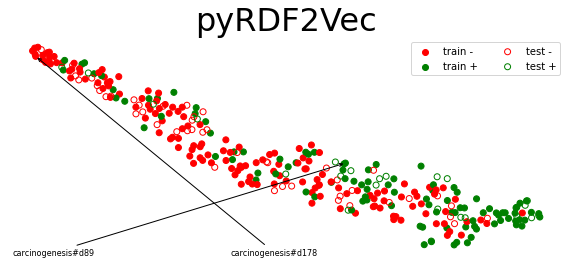

In [29]:
# Set the graph with a certain size.
plt.figure(figsize=(10, 4))

# Plot the train embeddings.
plt.scatter(
    X_tsne[: len(train_entities), 0],
    X_tsne[: len(train_entities), 1],
    edgecolors=[color_map[i] for i in labels[: len(train_entities)]],
    facecolors=[color_map[i] for i in labels[: len(train_entities)]],
)

# Plot the test embeddings.
plt.scatter(
    X_tsne[len(train_entities) :, 0],
    X_tsne[len(train_entities) :, 1],
    edgecolors=[color_map[i] for i in labels[len(train_entities) :]],
    facecolors="none",
)

# Annotate few points.
plt.annotate(
    entities[25].split("/")[-1],
    xy=(X_tsne[25, 0], X_tsne[25, 1]),
    xycoords="data",
    xytext=(0.01, 0.0),
    fontsize=8,
    textcoords="axes fraction",
    arrowprops=dict(arrowstyle="->", facecolor="black"),
)
plt.annotate(
    entities[35].split("/")[-1],
    xy=(X_tsne[35, 0], X_tsne[35, 1]),
    xycoords="data",
    xytext=(0.4, 0.0),
    fontsize=8,
    textcoords="axes fraction",
    arrowprops=dict(arrowstyle="->", facecolor="black"),
)

# Create a legend.
plt.scatter([], [], edgecolors="r", facecolors="r", label="train -")
plt.scatter([], [], edgecolors="g", facecolors="g", label="train +")
plt.scatter([], [], edgecolors="r", facecolors="none", label="test -")
plt.scatter([], [], edgecolors="g", facecolors="none", label="test +")
plt.legend(loc="upper right", ncol=2)

# Display the graph with a title, removing the axes for
# better readability.
plt.title("pyRDF2Vec", fontsize=32)
plt.axis("off")
plt.show()